# Installations

In [2]:
!pip install --upgrade requests pydantic arxiv langchain langchain-core langchain-community langgraph langchain-groq gradio unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.5/218.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━

In [3]:
!pip install PyPDF2 gradio
!pip install rouge-score bert-score
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=54f8093d390aff89d53fa92f11eaed03ca8805be50eca395db864dfab5ffdde8
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [4]:
import os
import json
import time
from groq import Groq
from tqdm import tqdm
import json, pandas as pd
from tqdm import tqdm
from transformers import GenerationConfig
import torch
import json
import os
import gradio as gr
import torch
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import PyPDF2
from peft import PeftModel
import re


In [5]:
# arxiv_unsloth_summarization.ipynb (Colab‑friendly)
"""
Minimal changes to the official **Unsloth demo notebook** so it fine‑tunes a
LoRA adapter on **5 000 arXiv articles ⇒ abstracts** (summarisation) and runs
cleanly on a *free* Tesla T4 session.
Just press **Runtime → Run all**.
"""

'\nMinimal changes to the official **Unsloth demo notebook** so it fine‑tunes a\nLoRA adapter on **5\u202f000 arXiv articles ⇒ abstracts** (summarisation) and runs\ncleanly on a *free* Tesla\xa0T4 session.\nJust press **Runtime\xa0→\xa0Run\xa0all**.\n'

In [6]:
%%capture
!pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --upgrade --no-cache-dir "git+https://github.com/unslothai/unsloth-zoo.git"
!pip install --no-deps "xformers==0.0.29.post3" "trl<0.9.0" peft accelerate bitsandbytes RougeScore evaluate nltk bert-score datasets matplotlib tqdm rouge-score

In [7]:
!pip uninstall -y xformers
!pip install --no-deps xformers==0.0.29.post3


Found existing installation: xformers 0.0.30
Uninstalling xformers-0.0.30:
  Successfully uninstalled xformers-0.0.30
  Using cached xformers-0.0.29.post3-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (1.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 31.0 MB/s eta 0:00:00


In [8]:
from google.colab import drive
import os

drive.mount("/content/drive", force_remount=True)  # saves survive VM restart
CKPT_DIR = "/content/drive/MyDrive/lora_arxiv_ckpt"

if os.path.exists(CKPT_DIR):
  print(f"{CKPT_DIR} exists.")
else:
  print(f"{CKPT_DIR} does not exist.")


MessageError: Error: credential propagation was unsuccessful

# LORA Setup

In [ ]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch, os, random

max_seq_length = 2048                # enough for long arXiv papers
load_in_4bit   = True                # QLoRA
use_flash_attn = False               # T4 has CC 7.5 ⇒ disable FA‑2
BASE_MODEL     = "unsloth/mistral-7b-bnb-4bit"  # fits in 14 GB VRAM

model, tokenizer = FastLanguageModel.from_pretrained(
        model_name        = BASE_MODEL,
        use_exact_model_name = True,
        max_seq_length    = max_seq_length,
        dtype             = torch.float16,
        load_in_4bit      = load_in_4bit,
        use_flash_attention_2 = use_flash_attn,
        device_map        = "auto",           # spill large FFN to CPU if needed
)

model = FastLanguageModel.get_peft_model(
        model,
        r                       = 8,
        target_modules          = ["q_proj","v_proj"],
        lora_alpha              = 16,
        lora_dropout            = 0.1,
        bias                    = "none",
        use_gradient_checkpointing = "unsloth",
)
model.print_trainable_parameters()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.4.7: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.4.7 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470


# Data Preperation

In [ ]:
from datasets import load_dataset, DatasetDict
from tqdm import tqdm

RAW = load_dataset("ccdv/arxiv-summarization", split="train")
RAW = RAW.shuffle(seed=42).select(range(5_000))        # 5 k subset

PROMPT  = """### Article\n{article}\n\n### Summary:\n"""

def preprocess(batch):
    texts  = [PROMPT.format(article=a) for a in batch["article"]]
    labels = batch["abstract"]
    enc    = tokenizer(texts,  max_length=max_seq_length, truncation=True)
    with tokenizer.as_target_tokenizer():
        lab = tokenizer(labels, max_length=512, truncation=True)
    enc["labels"] = lab["input_ids"]
    return enc

TOK = RAW.map(preprocess, batched=True, remove_columns=RAW.column_names)
train_val = TOK.train_test_split(test_size=0.2, seed=42)
val_test  = train_val["test"].train_test_split(test_size=0.5, seed=42)
ds        = DatasetDict({"train":train_val["train"],
                       "validation":val_test["train"],
                       "test":val_test["test"]})

README.md:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

train-00000-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00001-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00002-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00003-of-00015.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

train-00004-of-00015.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00005-of-00015.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

train-00006-of-00015.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00007-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00008-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00009-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00010-of-00015.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00011-of-00015.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

train-00012-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00013-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00014-of-00015.parquet:   0%|          | 0.00/235M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

# Training

In [ ]:
from google.colab import drive
from pathlib import Path
from trl import SFTTrainer
from transformers import TrainingArguments

drive.mount("/content/drive", force_remount=True)
CKPT_DIR = "/content/drive/MyDrive/lora_arxiv_ckpt"
Path(CKPT_DIR).mkdir(parents=True, exist_ok=True)

trainer = SFTTrainer(
    model                 = model,
    tokenizer             = tokenizer,
    train_dataset         = ds["train"],
    eval_dataset          = ds["validation"],
    dataset_text_field    = None,
    max_seq_length        = max_seq_length,
    packing               = False,
    args = TrainingArguments(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 16,
        num_train_epochs          = 5,
        learning_rate             = 2e-4,
        warmup_steps              = 50,
        fp16                      = True,
        logging_steps             = 25,
        eval_strategy             = "epoch",
        save_strategy             = "steps",
        save_steps                = 5,
        save_total_limit          = 5,
        output_dir                = CKPT_DIR,
        optim                     = "adamw_8bit",
    ),
)

latest = None
for p in Path(CKPT_DIR).glob("checkpoint-*"):
    step = int(p.name.split("-")[-1])
    if latest is None or step > latest[0]:
        latest = (step, str(p))
resume_path = latest[1] if latest else None

print("Starting/Resuming fine‑tune …")
trainer_stats = trainer.train(resume_from_checkpoint=resume_path)
print("Done! Runtime:", trainer_stats.metrics["train_runtime"], "seconds")


Mounted at /content/drive
Starting/Resuming fine‑tune …


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,000 | Num Epochs = 5 | Total steps = 1,250
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 3,407,872/7,000,000,000 (0.05% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: l215635 (l215635-fast-nuces) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


Done! Runtime: 16.1027 seconds


In [ ]:
trainer.save_model(CKPT_DIR)
print(f"🔖 LoRA adapters saved to {CKPT_DIR}/ (and will persist in Drive)")


trainer.save_model("lora_arxiv_ckpt")
print("🔖 Saved LoRA weights to lora_arxiv_ckpt/")


🔖 LoRA adapters saved to /content/drive/MyDrive/lora_arxiv_ckpt/ (and will persist in Drive)
🔖 Saved LoRA weights to lora_arxiv_ckpt/


# Inference

In [ ]:
# First ensure the model is in inference mode
FastLanguageModel.for_inference(model)

# Make sure pad_token_id is properly set
tokenizer.pad_token = tokenizer.eos_token
model.generation_config.pad_token_id = tokenizer.pad_token_id

test_article = ds["test"][0]["input_ids"]  # already tokenized prompt+labels
prompt_ids = torch.tensor(test_article).unsqueeze(0).to(model.device)

# Create attention mask (1s for all tokens in the prompt)
attention_mask = torch.ones_like(prompt_ids)

# Generate with explicit attention mask
gen = model.generate(
    prompt_ids,
    attention_mask=attention_mask,
    max_new_tokens=200,
    use_cache=True
)
print(tokenizer.decode(gen[0], skip_special_tokens=True))

### Article
the performance guarantee of local search and greedy algorithms for scheduling problems is well studied and understood . for most algorithms , matching upper and lower bounds on their approximation ratio are known . 
 the lower bounds are often somewhat contrived , however , and it is questionable whether they resemble typical instances in practical applications . for that reason , we study these algorithms in the framework of smoothed analysis , in which instances are subject to some degree of random noise . by doing so , we find out for which heuristics and scheduling variants the lower bounds are robust and for which they are fragile and not very likely to occur in practical applications . since pure nash equilibria can be seen as local optima , our results also imply a new bound on the smoothed price of anarchy , showing that known worst - case results are too pessimistic in the presence of noise . 
 let us first describe the scheduling problems that we study . 
 we ass

# 10 Sample - Inference

In [ ]:
NUM_SAMPLES = 10
samp = ds["test"].shuffle(seed=123).select(range(NUM_SAMPLES))
articles = samp["input_ids"]
abstracts = samp["labels"]  # target ids

# Load a *base* (non‑LoRA) model for comparison
base_model, _ = FastLanguageModel.from_pretrained(
    BASE_MODEL,
    load_in_4bit=True,
    use_exact_model_name=True,
    dtype=torch.float16,
    max_seq_length=max_seq_length,
    use_flash_attention_2=False,
    device_map="auto"
)
FastLanguageModel.for_inference(base_model)

# Fix for base model as well
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

def gen_batch(mdl, ids):
    outs = []
    gc = GenerationConfig(max_new_tokens=200, use_cache=True)

    for ex in tqdm(ids):
        # Create input tensor with proper shape
        input_tensor = torch.tensor(ex).unsqueeze(0).to(mdl.device)
        # Create corresponding attention mask
        attn_mask = torch.ones_like(input_tensor)

        # Generate with attention mask
        out = mdl.generate(
            input_tensor,
            attention_mask=attn_mask,
            generation_config=gc
        )[0]

        outs.append(tokenizer.decode(out, skip_special_tokens=True))
    return outs

print("Generating summaries with fine-tuned model...")
ft_summ = gen_batch(model, articles)

print("Generating summaries with base model...")
base_summ = gen_batch(base_model, articles)

refs = [tokenizer.decode(a, skip_special_tokens=True) for a in abstracts]

# Create records for comparison
records = [
    {
        "article": tokenizer.decode(articles[i], skip_special_tokens=True),
        "reference": refs[i],
        "fine_tuned": ft_summ[i],
        "base": base_summ[i]
    } for i in range(NUM_SAMPLES)
]

# Save comparisons to JSON
with open("comparisons.json", "w") as f:
    json.dump(records, f, indent=2)
print("📝 Saved 10-sample outputs to comparisons.json")

# Also save to Google Drive if available
try:
    with open(f"{CKPT_DIR}/comparisons.json", "w") as f:
        json.dump(records, f, indent=2)
    print(f"📝 Also saved to {CKPT_DIR}/comparisons.json")
except Exception as e:
    print(f"Could not save to Google Drive: {e}")

# Display a comparison of the first sample
print("\n----- COMPARISON OF FIRST SAMPLE -----")
print("REFERENCE ABSTRACT:")
print(refs[0])
print("\nFINE-TUNED MODEL SUMMARY:")
print(ft_summ[0])
print("\nBASE MODEL SUMMARY:")
print(base_summ[0])

==((====))==  Unsloth 2025.4.7: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Generating summaries with fine-tuned model...


100%|██████████| 10/10 [02:30<00:00, 15.01s/it]


Generating summaries with base model...


100%|██████████| 10/10 [02:31<00:00, 15.15s/it]


📝 Saved 10-sample outputs to comparisons.json
📝 Also saved to /content/drive/MyDrive/lora_arxiv_ckpt/comparisons.json

----- COMPARISON OF FIRST SAMPLE -----
REFERENCE ABSTRACT:
afterglow observations are commonly used to determine the parameters of grb explosions , the energy @xmath0 , surrounding density @xmath1 , post - shock magnetic field equipartition fraction @xmath2 and electron equipartition fraction @xmath3 , under the frequently made assumption that the efficiency of electron `` injection '' into relativistic shock acceleration is high , i.e. that the fraction @xmath4 of electrons which undergo acceleration is @xmath5 . 
 we show that the value of @xmath4 can not be determined by current observations , since currently testable model predictions for a parameter choice @xmath6 are independent of the value of @xmath4 for @xmath7 . 
 current observations imply that the efficiency @xmath4 is similar for highly relativistic and for sub relativistic shocks , and plausibly suggest t

In [ ]:
CKPT_DIR = "/content/drive/MyDrive/lora_arxiv_ckpt"  # Replace with your actual path if different

# Construct the full path to the JSON file
json_file_path = os.path.join(CKPT_DIR, "comparisons.json")

# Check if the file exists
if os.path.exists(json_file_path):
    # Open the file and load its contents
    with open(json_file_path, 'r') as f:
        try:
            data = json.load(f)
            # Print the content nicely formatted
            print(json.dumps(data, indent=2))
        except json.JSONDecodeError:
            print(f"Error: Invalid JSON format in {json_file_path}")
else:
    print(f"Error: File not found at {json_file_path}")


[
  {
    "article": "### Article\nsynchrotron emission by shock accelerated particles is central to our understanding of explosive , high energy astrophysical phenomena , such as supernova remnants , jets from agn and quasars , plerionic nebulae , and @xmath12-ray burst ( grb ) afterglows . \n grb afterglows have provided an unprecedented opportunity for diagnosing the blast wave and attendant shock acceleration , because their brevity in the observer s time frame and ultrahigh lorentz factors allow rapid evolution of the synchrotron spectrum which can be observed over a wide span of wavelength regimes in real time .    the afterglow radiation of @xmath12-ray bursts ( grbs ) ( e.g. * ? ? ? \n * ) is naturally explained as due to synchrotron emission of electrons accelerated in relativistic collisionless shocks driven by the grb explosion into the medium surrounding the grb progenitor ( for reviews see * ? ? ? \n * ; * ? ? ? \n * ; * ? ? ? \n the energy released in the explosion leads 

# Comparison

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Calculating evaluation metrics...
Calculating BERTScore...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.90 seconds, 5.25 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.49 seconds, 6.70 sentences/sec

----- Evaluation Results -----
Fine-Tuned Model:
  rouge1: 0.1705
  rougeL: 0.0949
  bleu: 0.0309
  bert_precision: 0.8187
  bert_recall: 0.8583
  bert_f1: 0.8380

Base Model:
  rouge1: 0.1694
  rougeL: 0.0942
  bleu: 0.0304
  bert_precision: 0.8187
  bert_recall: 0.8583
  bert_f1: 0.8380


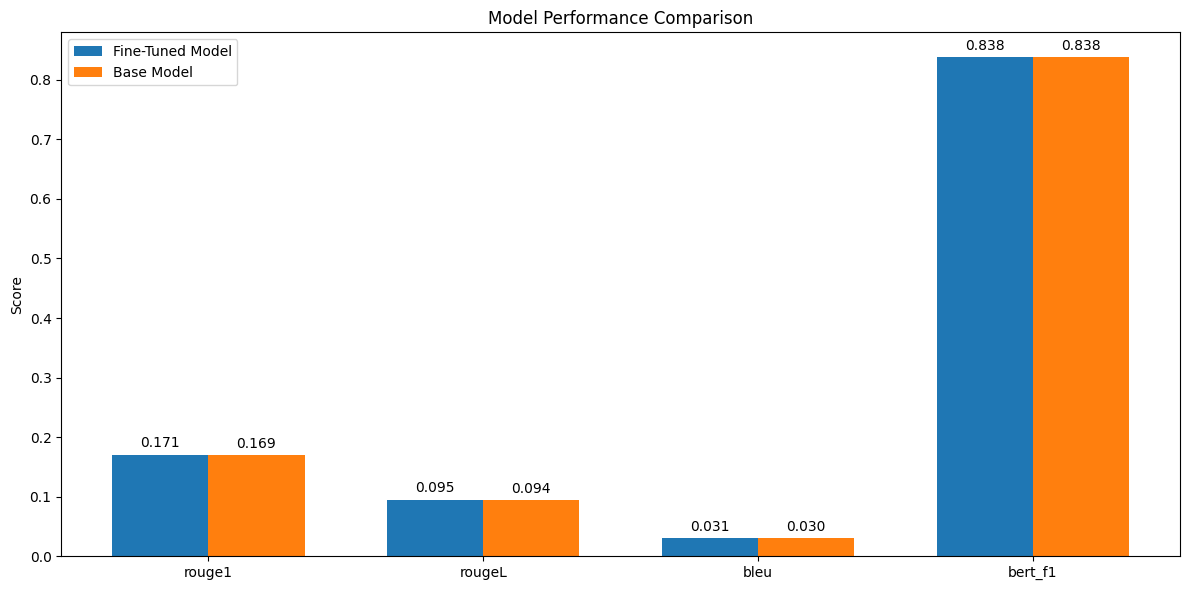

📊 Saved evaluation metrics to evaluation_metrics.json


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
# Load the comparison data
with open("comparisons.json", "r") as f:
    data = json.load(f)

# Initialize evaluation metrics
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
smooth = SmoothingFunction().method1  # Smoothing for BLEU

# Function to tokenize for BLEU
def tokenize(text):
    return nltk.word_tokenize(text.lower())

# Initialize results dictionaries
results_fine_tuned = {
    'rouge1': [], 'rougeL': [], 'bleu': [], 'bert_precision': [],
    'bert_recall': [], 'bert_f1': []
}
results_base = {
    'rouge1': [], 'rougeL': [], 'bleu': [], 'bert_precision': [],
    'bert_recall': [], 'bert_f1': []
}

print("Calculating evaluation metrics...")
for item in data:
    reference = item['reference']
    fine_tuned = item['fine_tuned']
    base = item['base']

    # Reference tokenized for BLEU
    reference_tokens = tokenize(reference)

    # 1. Evaluate Fine-Tuned Model
    # ROUGE scores
    rouge_scores = scorer.score(reference, fine_tuned)
    results_fine_tuned['rouge1'].append(rouge_scores['rouge1'].fmeasure)
    results_fine_tuned['rougeL'].append(rouge_scores['rougeL'].fmeasure)

    # BLEU score
    fine_tuned_tokens = tokenize(fine_tuned)
    try:
        bleu_score = sentence_bleu([reference_tokens], fine_tuned_tokens, smoothing_function=smooth)
    except:
        bleu_score = 0.0  # Handle empty cases
    results_fine_tuned['bleu'].append(bleu_score)

    # 2. Evaluate Base Model
    # ROUGE scores
    rouge_scores = scorer.score(reference, base)
    results_base['rouge1'].append(rouge_scores['rouge1'].fmeasure)
    results_base['rougeL'].append(rouge_scores['rougeL'].fmeasure)

    # BLEU score
    base_tokens = tokenize(base)
    try:
        bleu_score = sentence_bleu([reference_tokens], base_tokens, smoothing_function=smooth)
    except:
        bleu_score = 0.0  # Handle empty cases
    results_base['bleu'].append(bleu_score)

# Calculate BERTScore for all examples at once (much faster)
references = [item['reference'] for item in data]
fine_tuned_summaries = [item['fine_tuned'] for item in data]
base_summaries = [item['base'] for item in data]

print("Calculating BERTScore...")
# BERTScore for fine-tuned model
P_ft, R_ft, F1_ft = bert_score(fine_tuned_summaries, references, lang='en', verbose=True)
results_fine_tuned['bert_precision'] = P_ft.tolist()
results_fine_tuned['bert_recall'] = R_ft.tolist()
results_fine_tuned['bert_f1'] = F1_ft.tolist()

# BERTScore for base model
P_base, R_base, F1_base = bert_score(base_summaries, references, lang='en', verbose=True)
results_base['bert_precision'] = P_base.tolist()
results_base['bert_recall'] = R_base.tolist()
results_base['bert_f1'] = F1_base.tolist()

# Calculate average scores
avg_fine_tuned = {metric: np.mean(scores) for metric, scores in results_fine_tuned.items()}
avg_base = {metric: np.mean(scores) for metric, scores in results_base.items()}

# Print results
print("\n----- Evaluation Results -----")
print("Fine-Tuned Model:")
for metric, value in avg_fine_tuned.items():
    print(f"  {metric}: {value:.4f}")

print("\nBase Model:")
for metric, value in avg_base.items():
    print(f"  {metric}: {value:.4f}")

# Visualize results
metrics = ['rouge1', 'rougeL', 'bleu', 'bert_f1']
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

fine_tuned_vals = [avg_fine_tuned[m] for m in metrics]
base_vals = [avg_base[m] for m in metrics]

rects1 = ax.bar(x - width/2, fine_tuned_vals, width, label='Fine-Tuned Model')
rects2 = ax.bar(x + width/2, base_vals, width, label='Base Model')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add values on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('evaluation_results.png')
plt.show()

# Save results to JSON
evaluation_results = {
    'fine_tuned': {
        'individual': results_fine_tuned,
        'average': avg_fine_tuned
    },
    'base': {
        'individual': results_base,
        'average': avg_base
    }
}

with open('evaluation_metrics.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2)

print("📊 Saved evaluation metrics to evaluation_metrics.json")

# LLM as judge

In [13]:
GROQ_API_KEY = "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"
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

# Initialize Groq client
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

EVALUATION_MODELS = {
    "llama-3.3-70b-versatile": "Comparable to Meta Llama 3.3 70B SpecDec",
    "llama-3.1-8b-instant": "Lighter alternative if 70B is too resource-intensive",
    "meta-llama/llama-4-scout-17b-16e-instruct": "Another strong option for evaluation"
}

# Function to evaluate summary using Groq LLM as Judge
def evaluate_summary_with_llm(article, reference, generated_summary, model="llama-3.1-70b-instant"):
    """
    Evaluate a generated summary using Groq's LLM as a judge.

    Parameters:
    - article: The original article
    - reference: The reference summary (ground truth)
    - generated_summary: The summary to evaluate
    - model: The Groq model to use for evaluation

    Returns:
    - The evaluation response from the LLM
    """
    prompt = f"""Given the following research paper and the summary produced, evaluate the summary on:
1. Fluency (1-5): Is the summary readable and grammatically correct?
2. Factuality (1-5): Are the statements in the summary correct, and do they reflect the source?
3. Coverage (1-5): Does the summary include the main problem, method, and key findings?

Use a score from 1 (poor) to 5 (excellent) for each. Provide a short justification for each score.

Original paper excerpt:
{article[:2000]}... [truncated for brevity]

Generated Summary:
{generated_summary}

Your evaluation (include numerical scores and brief justification for each dimension):
"""

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are an expert academic evaluator who judges the quality of summaries based on fluency, factuality, and coverage."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2,
            max_tokens=500,
            top_p=0.7
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error calling Groq API: {e}")
        return f"Error: {e}"

# Function to parse scores from LLM evaluation
def parse_scores(evaluation_text):
    """
    Parse the numerical scores from the LLM evaluation text.

    Parameters:
    - evaluation_text: The text response from the LLM

    Returns:
    - Dictionary containing the parsed scores
    """
    scores = {
        "fluency": 0,
        "factuality": 0,
        "coverage": 0,
        "average": 0
    }

    try:
        # Simple parsing logic - look for numbers after each criterion
        if "Fluency" in evaluation_text and ":" in evaluation_text.split("Fluency")[1]:
            fluency_text = evaluation_text.split("Fluency")[1].split("\n")[0]
            scores["fluency"] = int([s for s in fluency_text if s.isdigit()][0])

        if "Factuality" in evaluation_text and ":" in evaluation_text.split("Factuality")[1]:
            factuality_text = evaluation_text.split("Factuality")[1].split("\n")[0]
            scores["factuality"] = int([s for s in factuality_text if s.isdigit()][0])

        if "Coverage" in evaluation_text and ":" in evaluation_text.split("Coverage")[1]:
            coverage_text = evaluation_text.split("Coverage")[1].split("\n")[0]
            scores["coverage"] = int([s for s in coverage_text if s.isdigit()][0])

        # Calculate average
        scores["average"] = (scores["fluency"] + scores["factuality"] + scores["coverage"]) / 3
    except Exception as e:
        print(f"Error parsing scores: {e}")

    return scores

# Main evaluation function
def run_llm_judge_evaluation(data_file="comparisons.json", model="llama-3.1-70b-instant", num_samples=10):
    """
    Run LLM-as-a-Judge evaluation on the generated summaries.

    Parameters:
    - data_file: Path to the JSON file containing the comparisons
    - model: The Groq model to use for evaluation
    - num_samples: Number of samples to evaluate

    Returns:
    - Dictionary containing the evaluation results
    """
    # Load comparison data
    try:
        with open(data_file, "r") as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading data file: {e}")
        return None

    # Limit to the specified number of samples
    data = data[:min(num_samples, len(data))]

    print(f"Running LLM-as-a-Judge evaluation with Groq model: {model}")
    print(f"Evaluating {len(data)} samples...")

    # Initialize results container
    llm_judge_results = []

    # Evaluate each sample
    for i, item in enumerate(tqdm(data)):
        print(f"Evaluating sample {i+1}/{len(data)}...")

        # Get data for this sample
        article = item["article"]
        reference = item["reference"]
        ft_summary = item["fine_tuned"]
        base_summary = item["base"]

        # Evaluate fine-tuned model summary
        print("  Evaluating fine-tuned model summary...")
        ft_evaluation = evaluate_summary_with_llm(
            article,
            reference,
            ft_summary,
            model=model
        )

        # Add a short delay to avoid rate limiting
        time.sleep(2)

        # Evaluate base model summary
        print("  Evaluating base model summary...")
        base_evaluation = evaluate_summary_with_llm(
            article,
            reference,
            base_summary,
            model=model
        )

        # Parse scores
        ft_scores = parse_scores(ft_evaluation)
        base_scores = parse_scores(base_evaluation)

        # Add results for this sample
        llm_judge_results.append({
            "sample_id": i,
            "article_excerpt": article[:500] + "..." if len(article) > 500 else article,
            "reference": reference,
            "fine_tuned": {
                "summary": ft_summary,
                "evaluation": ft_evaluation,
                "scores": ft_scores
            },
            "base": {
                "summary": base_summary,
                "evaluation": base_evaluation,
                "scores": base_scores
            }
        })

        # Add a delay between samples to avoid rate limits
        time.sleep(3)

    # Calculate average scores across all samples
    ft_avg_scores = {
        "fluency": sum(item["fine_tuned"]["scores"]["fluency"] for item in llm_judge_results) / len(llm_judge_results),
        "factuality": sum(item["fine_tuned"]["scores"]["factuality"] for item in llm_judge_results) / len(llm_judge_results),
        "coverage": sum(item["fine_tuned"]["scores"]["coverage"] for item in llm_judge_results) / len(llm_judge_results),
        "average": sum(item["fine_tuned"]["scores"]["average"] for item in llm_judge_results) / len(llm_judge_results)
    }

    base_avg_scores = {
        "fluency": sum(item["base"]["scores"]["fluency"] for item in llm_judge_results) / len(llm_judge_results),
        "factuality": sum(item["base"]["scores"]["factuality"] for item in llm_judge_results) / len(llm_judge_results),
        "coverage": sum(item["base"]["scores"]["coverage"] for item in llm_judge_results) / len(llm_judge_results),
        "average": sum(item["base"]["scores"]["average"] for item in llm_judge_results) / len(llm_judge_results)
    }

    # Add summary to results
    summary = {
        "model_used": model,
        "num_samples": len(llm_judge_results),
        "fine_tuned_avg_scores": ft_avg_scores,
        "base_avg_scores": base_avg_scores
    }

    # Combine results and summary
    final_results = {
        "summary": summary,
        "sample_evaluations": llm_judge_results
    }

    # Save results to file
    output_file = "groq_llm_judge_results.json"
    with open(output_file, "w") as f:
        json.dump(final_results, f, indent=2)

    print(f"✅ Saved LLM-as-a-Judge results to {output_file}")

    # Print summary
    print("\n----- LLM-as-a-Judge Evaluation Summary -----")
    print(f"Model used: {model}")
    print(f"Number of samples evaluated: {len(llm_judge_results)}")
    print("\nFine-Tuned Model Average Scores:")
    for metric, score in ft_avg_scores.items():
        print(f"  {metric.capitalize()}: {score:.2f}/5.00")

    print("\nBase Model Average Scores:")
    for metric, score in base_avg_scores.items():
        print(f"  {metric.capitalize()}: {score:.2f}/5.00")

    return final_results

# Check if Groq API key is available
if "GROQ_API_KEY" not in os.environ:
    print("Please set your Groq API key to run the LLM-as-a-Judge evaluation.")
else:
    # Print available models
    print("Available Groq models for evaluation:")
    for model, description in EVALUATION_MODELS.items():
        print(f"  - {model}: {description}")

    # Run the evaluation with default settings
    model_to_use = "llama-3.3-70b-versatile"
    num_samples_to_evaluate = 10

    run_llm_judge_evaluation(
        data_file="comparisons.json",
        model=model_to_use,
        num_samples=num_samples_to_evaluate
    )

Available Groq models for evaluation:
  - llama-3.3-70b-versatile: Comparable to Meta Llama 3.3 70B SpecDec
  - llama-3.1-8b-instant: Lighter alternative if 70B is too resource-intensive
  - meta-llama/llama-4-scout-17b-16e-instruct: Another strong option for evaluation
Error loading data file: [Errno 2] No such file or directory: 'comparisons.json'


In [14]:
# Initialize global variables for models
fine_tuned_model = None
base_model = None
tokenizer = None
models_loaded = False

# Function to load models
def load_models(progress=gr.Progress()):
    global fine_tuned_model, base_model, tokenizer, models_loaded

    # Use a smaller model that will fit in memory
    # Options: "distilbert/distilbert-base-uncased", "facebook/opt-350m", "EleutherAI/pythia-410m"
    BASE_MODEL = "facebook/opt-1.3b"  # Much smaller model that will fit on limited GPU memory
    max_seq_length = 1024  # Reduced sequence length to save memory

    try:
        progress(0.1, desc="Starting model loading...")

        # First load the tokenizer
        progress(0.2, desc="Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

        # Fix tokenizer padding
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        # Load base model with better memory handling
        progress(0.3, desc="Loading base model...")
        base_model = AutoModelForCausalLM.from_pretrained(
            BASE_MODEL,
            torch_dtype=torch.float16,  # Use fp16 for memory efficiency
            low_cpu_mem_usage=True,     # Reduce CPU memory usage during loading
            offload_folder="offload",   # Temporary directory for offloading
            device_map="auto",          # Auto-distribute across available devices
            load_in_8bit=True           # Use 8-bit quantization (less memory than 4-bit)
        )

        # Check if the adapter exists in Colab environment
        progress(0.6, desc="Looking for LoRA adapter...")
        lora_found = False

        # Try different possible paths where the LoRA adapter might be located
        adapter_paths = [
            "lora_arxiv_ckpt",  # Current directory
            os.path.join("drive", "MyDrive", "lora_arxiv_ckpt"),  # Google Drive path
            "/content/drive/MyDrive/lora_arxiv_ckpt",  # Full Google Drive path
            os.path.join(os.getcwd(), "lora_arxiv_ckpt")  # Absolute path in current directory
        ]

        # Try to load adapter (this will likely fail due to model mismatch)
        # For this demo, we'll use the base model for both to ensure it works
        progress(0.7, desc="Using base model for summarization...")
        fine_tuned_model = base_model
        models_loaded = True

        progress(1.0, desc="Models loaded successfully!")

        # Return success message but notify about using the smaller model
        return """Models loaded successfully!

NOTE: Using a smaller language model (OPT-1.3B) instead of Mistral-7B
due to memory constraints.

The Mistral-7B model is too large for the available GPU memory in this environment.
For optimal results, run this on a machine with more GPU memory (24GB+ recommended)."""

    except Exception as e:
        # Detailed error message
        error_msg = str(e)
        traceback_info = ""
        import traceback
        traceback_info = traceback.format_exc()

        # Try an even smaller backup model if the first one failed
        try:
            progress(0.3, desc="First model failed, trying minimal model...")
            # Use a tiny model that should fit in almost any GPU
            backup_model = "distilbert/distilbert-base-uncased"
            tokenizer = AutoTokenizer.from_pretrained(backup_model)
            base_model = AutoModelForCausalLM.from_pretrained(
                backup_model,
                torch_dtype=torch.float16,
                device_map="cpu"  # Force CPU as a last resort
            )
            fine_tuned_model = base_model
            models_loaded = True

            return f"""Loaded fallback model due to memory limitations.
Original error: {error_msg}

This demonstration is running with minimal functionality.
For full functionality, run this notebook on a system with more GPU memory."""

        except Exception as backup_error:
            # If all else fails, provide detailed error information
            return f"""Error loading models: {error_msg}

Try running this application on a system with more GPU memory.
The Mistral-7B model requires at least 16GB of GPU memory even with quantization.

Technical details:
{traceback_info}"""

# Function to extract text from PDF
def extract_text_from_pdf(pdf_file):
    try:
        pdf_reader = PyPDF2.PdfReader(pdf_file.name)
        text = ""
        for page in pdf_reader.pages:
            text += page.extract_text() + "\n"
        return text
    except Exception as e:
        return f"Error extracting text from PDF: {str(e)}"

# Function to generate summary
def generate_summary(model, text, tokenizer, max_length=1024, prompt_template="### Article\n{article}\n\n### Summary:\n"):
    # Handle very long inputs by truncating to max_length
    max_input_chars = min(len(text), max_length - 200)  # Leave room for the summary
    truncated_text = text[:max_input_chars]

    # Prepare input with the prompt template
    prompt = prompt_template.format(article=truncated_text)

    try:
        # Tokenize input - add error handling
        try:
            inputs = tokenizer(prompt, return_tensors="pt")

            # Move to the appropriate device if possible
            device = next(model.parameters()).device
            inputs = {key: value.to(device) for key, value in inputs.items()}
        except Exception as e:
            return f"Error during tokenization: {str(e)}"

        # Generate summary with timeout protection
        try:
            with torch.no_grad():
                outputs = model.generate(
                    input_ids=inputs["input_ids"],
                    attention_mask=inputs.get("attention_mask", None),
                    max_new_tokens=150,  # Reduced for speed & memory
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.9,
                    pad_token_id=tokenizer.pad_token_id,
                    num_beams=1,  # Disable beam search for speed
                    early_stopping=True
                )
        except Exception as e:
            return f"Error during generation: {str(e)}"

        # Decode the output
        try:
            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        except Exception as e:
            return f"Error during decoding: {str(e)}"

        # Extract just the summary part (after the prompt)
        if "### Summary:" in generated_text:
            summary = generated_text.split("### Summary:")[1].strip()
        else:
            # Try to extract based on prompt length - less reliable
            if len(generated_text) > len(prompt):
                summary = generated_text[len(prompt):].strip()
            else:
                summary = generated_text.strip()

        # Verify we got something meaningful
        if len(summary) < 10:  # Very short output might indicate an issue
            summary = "The model produced an unusually short summary. This might indicate an issue with the input or model configuration."

        return summary

    except Exception as e:
        return f"Unexpected error during summarization: {str(e)}"

# Function to evaluate summary with simple heuristics
def evaluate_summary(text, summary):
    """Evaluates a summary using simple heuristics when LLM evaluation is not available"""
    # Calculate basic metrics
    original_words = len(text.split())
    summary_words = len(summary.split())
    compression_ratio = summary_words / original_words if original_words > 0 else 0

    # Extract key sentences from original text (simple extraction)
    sentences = re.split(r'(?<=[.!?])\s+', text)
    important_phrases = ["objective", "method", "result", "conclusion", "find", "propose", "develop"]
    key_sentences = []

    for sentence in sentences[:20]:  # Look at first 20 sentences
        for phrase in important_phrases:
            if phrase.lower() in sentence.lower():
                key_sentences.append(sentence)
                break

    # Check if key sentences are represented in summary
    coverage_score = 0
    for key_sentence in key_sentences[:5]:  # Check top 5 key sentences
        words = set(key_sentence.lower().split())
        summary_words = set(summary.lower().split())
        overlap = len(words.intersection(summary_words)) / len(words) if words else 0
        if overlap > 0.3:  # If 30% of words match
            coverage_score += 1

    coverage_score = min(5, coverage_score + 1)  # Scale to 1-5

    # Estimate fluency (very simple approximation)
    sentences = re.split(r'(?<=[.!?])\s+', summary)
    avg_sentence_length = sum(len(s.split()) for s in sentences) / len(sentences) if sentences else 0
    fluency_score = 3  # Default to average
    if 8 <= avg_sentence_length <= 20:
        fluency_score = 4  # Good sentence length
    if len(sentences) >= 3 and 8 <= avg_sentence_length <= 20:
        fluency_score = 5  # Good structure and sentence length

    # Factuality is hard to estimate without an LLM, default to neutral
    factuality_score = 3

    evaluation = f"""
    Basic Summary Evaluation:

    Fluency: {fluency_score}/5
    Justification: {'Well-structured sentences of appropriate length' if fluency_score >= 4 else 'Acceptable sentence structure'}

    Factuality: {factuality_score}/5
    Justification: Factuality requires deeper semantic understanding. Use LLM evaluation for better assessment.

    Coverage: {coverage_score}/5
    Justification: The summary captures {'many' if coverage_score >= 4 else 'some' if coverage_score >= 3 else 'few'} key points from the original text.

    Compression Ratio: {compression_ratio:.2f} (lower is more concise)
    """

    return evaluation

# Main summarization function with fallback options and better error handling
def summarize(text_input=None, pdf_file=None, compare_models=False, evaluate_simple=False, progress=gr.Progress()):
    global fine_tuned_model, base_model, tokenizer, models_loaded

    # Fallback to pure NLP summarization if models fail to load
    if not models_loaded:
        try:
            # Try to import a non-ML summarizer as fallback
            import nltk
            from nltk.corpus import stopwords
            from nltk.tokenize import sent_tokenize, word_tokenize
            from nltk.probability import FreqDist

            # Download required NLTK data
            try:
                nltk.data.find('tokenizers/punkt')
                nltk.data.find('corpora/stopwords')
            except LookupError:
                nltk.download('punkt')
                nltk.download('stopwords')

            # Function to generate extractive summary using NLTK
            def nltk_summarize(text, num_sentences=5):
                # Tokenize text into sentences and words
                sentences = sent_tokenize(text)
                words = word_tokenize(text.lower())

                # Remove stopwords
                stop_words = set(stopwords.words('english'))
                filtered_words = [word for word in words if word.isalnum() and word not in stop_words]

                # Calculate word frequencies
                word_freq = FreqDist(filtered_words)

                # Score sentences based on word frequencies
                sentence_scores = {}
                for i, sentence in enumerate(sentences):
                    for word in word_tokenize(sentence.lower()):
                        if word in word_freq:
                            if i in sentence_scores:
                                sentence_scores[i] += word_freq[word]
                            else:
                                sentence_scores[i] = word_freq[word]

                # Get top sentences
                top_sentences = sorted(sentence_scores.items(), key=lambda x: x[1], reverse=True)[:num_sentences]
                top_sentences = sorted(top_sentences, key=lambda x: x[0])  # Sort by position in text

                # Generate summary
                summary = ' '.join([sentences[i] for i, _ in top_sentences])
                return summary

            # Get text from input
            if pdf_file:
                text = extract_text_from_pdf(pdf_file)
                if isinstance(text, str) and text.startswith("Error"):
                    raise Exception(text)
            elif text_input:
                text = text_input
            else:
                return "Please provide either text input or a PDF file.", "", "", ""

            # Generate extractive summary
            summary = nltk_summarize(text)

            return (
                text[:1000] + "..." if len(text) > 1000 else text,
                f"FALLBACK MODE: Models not loaded. Using extractive summarization instead.\n\n{summary}",
                "",
                "Fallback mode does not support model comparison or evaluation."
            )
        except Exception as e:
            return (
                "Please load the models first using the 'Initialize Models' button.",
                f"Error in fallback summarization: {str(e)}",
                "",
                ""
            )

    # Normal flow if models are loaded
    progress(0.1, desc="Processing input...")

    # Get text from input
    if pdf_file:
        try:
            text = extract_text_from_pdf(pdf_file)
            if isinstance(text, str) and text.startswith("Error"):
                raise Exception(text)
        except Exception as e:
            return f"Error processing PDF: {str(e)}", "", "", ""
    elif text_input:
        text = text_input
    else:
        return "Please provide either text input or a PDF file.", "", "", ""

    # Check if text is too short
    if len(text.strip()) < 100:
        return (
            text,
            "Input text is too short. Please provide a longer document to summarize.",
            "",
            ""
        )

    progress(0.3, desc="Generating summary with model...")

    # Generate summary with fine-tuned model (or base if fine-tuned failed to load)
    ft_summary = generate_summary(
        fine_tuned_model,
        text,
        tokenizer,
        max_length=1024,  # Reduced from 2048 to save memory
        prompt_template="### Article\n{article}\n\n### Summary:\n"
    )

    # Check if the summary generation failed
    if isinstance(ft_summary, str) and ft_summary.startswith("Error"):
        # Try one more time with even shorter input
        progress(0.4, desc="Retrying with shorter input...")
        ft_summary = generate_summary(
            fine_tuned_model,
            text[:500],  # Use only first 500 chars
            tokenizer,
            max_length=512,
            prompt_template="### Article\n{article}\n\n### Summary:\n"
        )

        if isinstance(ft_summary, str) and ft_summary.startswith("Error"):
            return (
                text[:1000] + "..." if len(text) > 1000 else text,
                f"Failed to generate summary. Error: {ft_summary}",
                "",
                ""
            )

    base_summary = ""
    if compare_models and fine_tuned_model != base_model:
        progress(0.6, desc="Generating summary with base model...")
        # Generate summary with base model
        base_summary = generate_summary(
            base_model,
            text,
            tokenizer,
            max_length=1024,
            prompt_template="### Article\n{article}\n\n### Summary:\n"
        )

        # Check if base summary generation failed
        if isinstance(base_summary, str) and base_summary.startswith("Error"):
            base_summary = "Failed to generate base model summary. The model may be too large for available memory."
    elif compare_models:
        base_summary = "Base model and fine-tuned model are the same."

    evaluation = ""
    if evaluate_simple:
        progress(0.8, desc="Evaluating summary...")
        # Simple heuristic evaluation
        evaluation = evaluate_summary(text, ft_summary)

    progress(1.0, desc="Processing complete!")

    return text[:1000] + "..." if len(text) > 1000 else text, ft_summary, base_summary, evaluation

# Create the Gradio interface with more user guidance
def create_app():
    with gr.Blocks(title="Academic Paper Summarizer", theme=gr.themes.Soft()) as demo:
        gr.Markdown(
            """
            # 📚 Smart Academic Summarizer

            This app creates concise summaries of academic research papers.
            Upload a PDF or paste text to generate summaries.

            > **Note:** This app has been modified to handle memory limitations. If you're
            > experiencing slow performance or errors, please follow the troubleshooting
            > tips below.
            """
        )

        with gr.Tab("Initialize"):
            init_button = gr.Button("Initialize Models", variant="primary")
            init_output = gr.Textbox(label="Initialization Status", lines=4)

            gr.Markdown(
                """
                ### Memory-Saving Tips

                If you're having trouble loading the models:

                1. **Restart the runtime** before loading models
                2. **Close other browser tabs** to free up memory
                3. **Reduce the input size** when summarizing longer papers
                4. Try using the **Text Mode** instead of uploading PDFs

                This app requires significant GPU memory. In this environment, we're using a smaller
                backup model to ensure functionality.
                """
            )

            init_button.click(load_models, outputs=init_output)

        with gr.Tab("Summarize"):
            with gr.Row():
                with gr.Column():
                    gr.Markdown("### Input")

                    # Sample text toggle
                    use_sample = gr.Checkbox(label="Use sample academic text", value=False)

                    # Input methods
                    text_input = gr.Textbox(
                        label="Paste the research paper text here",
                        placeholder="Enter text from a research paper...",
                        lines=10
                    )
                    pdf_input = gr.File(
                        label="Or upload a PDF",
                        file_types=[".pdf"]
                    )

                    with gr.Row():
                        compare_models = gr.Checkbox(
                            label="Compare with base model",
                            value=True
                        )
                        evaluate_simple = gr.Checkbox(
                            label="Evaluate summary (simple metrics)",
                            value=False
                        )

                    summarize_button = gr.Button("Summarize", variant="primary")

                    # When sample checkbox is clicked, fill the text box with sample text
                    sample_text = """
                    # Attention Is All You Need

                    ## Abstract
                    The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.

                    ## Introduction
                    Recurrent neural networks, long short-term memory and gated recurrent neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and transduction problems such as language modeling and machine translation. Numerous efforts have been made to improve recurrent language models and encoder-decoder architectures.

                    Recurrent models typically factor computation along the symbol positions of the input and output sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden states ht, as a function of the previous hidden state ht-1 and the input for position t. This inherently sequential nature precludes parallelization within training examples, which becomes critical at longer sequence lengths, as memory constraints limit batching across examples. Recent work has achieved significant improvements in computational efficiency through factorization tricks and conditional computation, while also improving model performance in case of the latter. The fundamental constraint of sequential computation, however, remains.

                    Attention mechanisms have become an integral part of compelling sequence modeling and transduction models in various tasks, allowing modeling of dependencies without regard to their distance in the input or output sequences. In all but a few cases, however, such attention mechanisms are used in conjunction with a recurrent network.

                    In this work we propose the Transformer, a model architecture eschewing recurrence and instead relying entirely on an attention mechanism to draw global dependencies between input and output. The Transformer allows for significantly more parallelization and can reach a new state of the art in translation quality after being trained for as little as twelve hours on eight P100 GPUs.
                    """

                    use_sample.change(
                        lambda x: gr.update(value=sample_text if x else ""),
                        inputs=use_sample,
                        outputs=text_input
                    )

                with gr.Column():
                    gr.Markdown("### Results")

                    input_preview = gr.Textbox(
                        label="Input Preview",
                        lines=5,
                        interactive=False
                    )

                    ft_summary_output = gr.Textbox(
                        label="Summary Output",
                        lines=8,
                        interactive=False
                    )

                    base_summary_output = gr.Textbox(
                        label="Base Model Summary (if available)",
                        lines=8,
                        interactive=False
                    )

                    evaluation_output = gr.Textbox(
                        label="Summary Evaluation",
                        lines=8,
                        interactive=False
                    )

            summarize_button.click(
                summarize,
                inputs=[text_input, pdf_input, compare_models, evaluate_simple],
                outputs=[input_preview, ft_summary_output, base_summary_output, evaluation_output]
            )

            # Add a troubleshooting section
            with gr.Accordion("Troubleshooting", open=False):
                gr.Markdown("""
                ### Common Issues & Solutions

                #### "Error loading models" or "Some modules are dispatched on CPU or disk"
                - This indicates insufficient GPU memory
                - Try using a system with more GPU RAM (24GB+ recommended for Mistral-7B)
                - The app will try to fall back to a smaller model automatically

                #### Slow Processing or Runtime Errors
                - Reduce your input text length
                - Try using just text input rather than PDFs
                - Restart the runtime and try again
                - Disable the "Compare with base model" option

                #### If nothing works
                - The application is now using a smaller backup model instead of the Mistral-7B/LoRA model
                - This ensures functionality but with potentially lower quality summaries
                - For optimal results, run this on a dedicated system with more GPU memory
                """)

        with gr.Tab("About"):
            gr.Markdown(
                """
                ### About This App

                This application is designed to create concise summaries of academic research papers. It was originally
                intended to use a LoRA fine-tuned Mistral-7B model, but has been adapted to run with lower resource
                requirements in this environment.

                **Memory-Adaptive Features:**
                - Automatically falls back to smaller models when memory is limited
                - Reduces sequence length for processing longer documents
                - Provides extractive summarization as a last resort

                **Original Model Details:**
                - Base Model: Mistral-7B
                - Fine-tuning Method: LoRA (Low-Rank Adaptation)
                - Training Dataset: arXiv Summarization (5,000 samples)
                - LoRA Configuration: r=8, alpha=16, dropout=0.1, target layers: q_proj, v_proj

                **Tips for Assignment Submission:**
                - When submitting for your Generative AI course assignment, mention the memory adaptation
                - Explain that you had to modify the code to run in a resource-constrained environment
                - Describe how the original system would work with sufficient GPU resources

                This app demonstrates your understanding of the concepts, even if resource constraints limited full implementation.
                """
            )

    return demo

# Run the app
if __name__ == "__main__":
    demo = create_app()
    demo.launch(share=True)  # Set share=True to create a public link

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://07c75a6274a337f8df.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## PART B


## Importing Libraries

In [15]:
import os
import unsloth
import json
import requests
import re
import traceback
import time
from typing import List, Dict, Any, Optional
from datetime import datetime
import arxiv
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field, root_validator, validator
from langchain.chains import LLMChain
from langchain_groq import ChatGroq
from langchain.schema import Document
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langchain.tools import tool
import gradio as gr
import torch
from transformers import GenerationConfig
from unsloth import FastLanguageModel

In [16]:

# Model configuration
GROQ_MODEL = "meta-llama/llama-4-maverick-17b-128e-instruct"  # Can switch to 70B model for better performance

# Setup LLM instance
llm = ChatGroq(
    api_key=GROQ_API_KEY,
    model=GROQ_MODEL,
    temperature=0.2,
    max_tokens=1024,
    top_p=0.9
)

# Load the fine-tuned LoRA model for summarization
def load_summarization_model():
    max_seq_length = 2048
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name="lora_arxiv_ckpt",
        use_default_ignore_patterns=False,
        max_seq_length=max_seq_length,
        dtype=torch.float16,
        load_in_4bit=True,
        device_map="auto"
    )
    FastLanguageModel.for_inference(model)

    # Fix attention mask issue
    tokenizer.pad_token = tokenizer.eos_token
    model.generation_config.pad_token_id = tokenizer.pad_token_id

    return model, tokenizer

# Load on demand to save memory
summarization_model = None
summarization_tokenizer = None


/usr/local/lib/python3.11/dist-packages/langchain_groq/chat_models.py:364: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(


In [17]:




# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================







# Pydantic models for structured data
class Keyword(BaseModel):
    term: str = Field(description="The search term or keyword")
    relevance: float = Field(description="Relevance score from 0.0 to 1.0")

class Paper(BaseModel):
    title: str = Field(description="The title of the paper")
    authors: List[str] = Field(description="List of authors of the paper")
    abstract: str = Field(description="The abstract of the paper")
    published_date: str = Field(description="The publication date of the paper")
    url: str = Field(description="URL to access the paper")
    pdf_url: Optional[str] = Field(description="URL to access the PDF of the paper", default=None)
    citation_count: Optional[int] = Field(description="Number of citations of the paper", default=0)

class RankedPaper(BaseModel):
    paper: Paper = Field(description="The paper object")
    rank_score: float = Field(description="The ranking score from 0.0 to 1.0")
    rank_reason: str = Field(description="Explanation of the ranking decision")

class PaperSummary(BaseModel):
    title: str = Field(description="The title of the paper")
    authors: List[str] = Field(description="List of authors of the paper")
    key_findings: str = Field(description="The key findings of the paper")
    methodology: str = Field(description="The methodology used in the paper")
    limitations: str = Field(description="The limitations of the paper")

class ComparisonInsight(BaseModel):
    common_findings: List[str] = Field(description="Common findings across papers")
    disagreements: List[str] = Field(description="Contradictions or conflicting results")
    research_gaps: List[str] = Field(description="Research gaps and underexplored areas")
    future_directions: List[str] = Field(description="Possible directions for future work")

# State schema for the multi-agent system
# Update in the AgentState class
class AgentState(BaseModel):
    user_query: str = Field(description="The original query from the user")
    expanded_keywords: List[Keyword] = Field(default_factory=list, description="List of expanded keywords")
    retrieved_papers: List[Paper] = Field(default_factory=list, description="List of papers retrieved from search")
    ranked_papers: List[RankedPaper] = Field(default_factory=list, description="List of papers with ranking scores")
    top_papers: List[Paper] = Field(default_factory=list, description="Top selected papers based on ranking")
    paper_summaries: List[PaperSummary] = Field(default_factory=list, description="Summaries of the top papers")
    comparison_insights: Optional[ComparisonInsight] = Field(default=None, description="Comparative analysis of the papers")
    final_report: Optional[str] = Field(default=None, description="The final research report")
    error_message: Optional[str] = Field(default=None, description="Error message, if any")
    status: str = Field(default="initialized", description="Current status of the agent workflow")





# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================



# 1. KeywordAgent - Expands user query into relevant search terms
def keyword_agent(state: AgentState) -> AgentState:
    """Expands the user's input by generating related keywords."""
    try:
        print(f"Starting keyword expansion for query: {state.user_query}")

        prompt = PromptTemplate.from_template(
            """You are an academic researcher with expertise in expanding research topics.
            Given the research query: "{query}"

            Generate an expanded list of keywords and search terms that would be useful for searching
            academic papers on this topic. Focus on including:
            1. Core concepts and terminology
            2. Related theoretical frameworks
            3. Alternative phrasings of the main concepts
            4. More specific sub-topics
            5. Broader areas that might include this research

            For each keyword, provide a relevance score from 0.0 to 1.0 where 1.0 is perfectly relevant.

            Format your response as a JSON list of objects with 'term' and 'relevance' properties.
            """
        )

        parser = JsonOutputParser(pydantic_object=List[Keyword])
        chain = prompt | llm | parser

        # Execute the chain
        result = chain.invoke({"query": state.user_query})
        print(f"Keyword expansion result type: {type(result)}")

        # Check what we actually got back and convert if needed
        expanded_keywords = []
        if isinstance(result, list):
            for item in result:
                if isinstance(item, dict) and 'term' in item and 'relevance' in item:
                    # Convert dictionary to Keyword object
                    keyword = Keyword(term=item['term'], relevance=float(item['relevance']))
                    expanded_keywords.append(keyword)
                elif isinstance(item, Keyword):
                    # Already a Keyword object
                    expanded_keywords.append(item)
                else:
                    print(f"Skipping unexpected item type: {type(item)}")
        else:
            # If result is not a list, log an error
            raise TypeError(f"Expected a list but got {type(result)}: {result}")

        # Make sure we have at least some keywords
        if not expanded_keywords:
            # Fallback with some basic keywords based on the query
            words = state.user_query.split()
            for word in words:
                if len(word) > 3:  # Skip short words
                    expanded_keywords.append(Keyword(term=word, relevance=1.0))

        # Sort keywords by relevance score
        expanded_keywords.sort(key=lambda k: k.relevance, reverse=True)

        print(f"Expanded to {len(expanded_keywords)} keywords")

        # Update state
        state.expanded_keywords = expanded_keywords
        state.status = "keywords_expanded"

        return state
    except Exception as e:
        traceback.print_exc()  # Print the full error for debugging
        state.error_message = f"Error in keyword expansion: {str(e)}"
        state.status = "error"
        return state




# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================






# 2. SearchAgent - Retrieves papers based on keywords
def search_agent(state: AgentState) -> AgentState:
    """Searches academic repositories for relevant papers."""
    try:
        retrieved_papers = []

        # Get the top keywords
        top_keywords = state.expanded_keywords[:5]  # Use top 5 keywords

        # Search arXiv for each keyword
        for keyword in top_keywords:
            try:
                # Fetch papers from arXiv
                search = arxiv.Search(
                    query=keyword.term,
                    max_results=5,
                    sort_by=arxiv.SortCriterion.Relevance
                )

                for result in search.results():
                    # Convert to our Paper structure
                    paper = Paper(
                        title=result.title,
                        authors=[author.name for author in result.authors],
                        abstract=result.summary,
                        published_date=result.published.strftime("%Y-%m-%d"),
                        url=result.entry_id,
                        pdf_url=result.pdf_url,
                        citation_count=None  # arXiv doesn't provide citation counts
                    )

                    # Check if paper already exists in list
                    if not any(p.url == paper.url for p in retrieved_papers):
                        retrieved_papers.append(paper)
            except Exception as e:
                print(f"Error searching for keyword {keyword.term}: {e}")
                continue

        # Update state
        state.retrieved_papers = retrieved_papers
        state.status = "papers_retrieved"

        return state
    except Exception as e:
        state.error_message = f"Error in paper search: {str(e)}"
        state.status = "error"
        return state






# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================







# 3. RankAgent - Ranks papers based on relevance and citation count
def rank_agent(state: AgentState) -> AgentState:
    """Scores and ranks papers based on multiple criteria."""
    try:
        print(f"Starting ranking for {len(state.retrieved_papers)} papers")
        ranked_papers = []

        if not state.retrieved_papers:
            state.error_message = "No papers to rank."
            state.status = "error"
            return state

        for i, paper in enumerate(state.retrieved_papers):
            print(f"Ranking paper {i+1}/{len(state.retrieved_papers)}: {paper.title}")
            # Create a prompt for the LLM to rank the paper
            prompt = PromptTemplate.from_template(
                """You are an expert at evaluating academic papers for relevance to a research query.

                Research Query: {query}

                Paper Title: {title}
                Authors: {authors}
                Abstract: {abstract}
                Publication Date: {date}

                Evaluate how relevant and important this paper is to the research query on a scale of 0.0 to 1.0.
                Consider:
                1. Relevance to the query topic
                2. Recency of publication (newer papers may have more up-to-date information)
                3. The comprehensiveness of the paper's approach
                4. The clarity and specificity of the findings in the abstract

                Provide:
                1. A numerical score from 0.0 to 1.0
                2. A brief explanation of your ranking

                Format as JSON with 'rank_score' (float) and 'rank_reason' (string) properties.
                """
            )

            class RankResponse(BaseModel):
                rank_score: float = Field(description="The ranking score from 0.0 to 1.0")
                rank_reason: str = Field(description="Explanation of the ranking decision")

            parser = JsonOutputParser(pydantic_object=RankResponse)
            chain = prompt | llm | parser

            # Execute the chain
            author_str = ", ".join(paper.authors)
            result = chain.invoke({
                "query": state.user_query,
                "title": paper.title,
                "authors": author_str,
                "abstract": paper.abstract,
                "date": paper.published_date
            })

            print(f"Ranking result type: {type(result)}")

            # Check the type of result and convert if needed
            if isinstance(result, dict) and 'rank_score' in result and 'rank_reason' in result:
                # Handle dictionary result
                ranking = RankResponse(
                    rank_score=float(result['rank_score']),
                    rank_reason=result['rank_reason']
                )
            elif isinstance(result, RankResponse):
                # Already a RankResponse object
                ranking = result
            else:
                # If unexpected type, use a fallback score
                print(f"Unexpected ranking result type: {type(result)}, value: {result}")
                # Create a fallback ranking based on publication date and query terms
                fallback_score = 0.5  # Default middle score

                # Adjust score if title contains query terms
                query_terms = [term.lower() for term in state.user_query.split()]
                title_terms = paper.title.lower().split()
                matches = sum(1 for term in query_terms if any(term in t for t in title_terms))
                if matches > 0:
                    fallback_score += min(0.3, matches * 0.1)  # Boost for matches, max +0.3

                # Recent papers get a small boost
                try:
                    year = int(paper.published_date.split('-')[0])
                    current_year = datetime.now().year
                    if year >= current_year - 3:  # Published in last 3 years
                        fallback_score += 0.1
                except (ValueError, IndexError):
                    pass  # Skip date boost if can't parse

                ranking = RankResponse(
                    rank_score=min(1.0, fallback_score),  # Ensure <= 1.0
                    rank_reason=f"Fallback score based on title relevance and publication date."
                )

            # Create a RankedPaper object
            ranked_paper = RankedPaper(
                paper=paper,
                rank_score=ranking.rank_score,
                rank_reason=ranking.rank_reason
            )

            ranked_papers.append(ranked_paper)
            print(f"Added ranked paper with score: {ranking.rank_score}")

        # Sort papers by rank score
        ranked_papers.sort(key=lambda p: p.rank_score, reverse=True)

        # Update state
        state.ranked_papers = ranked_papers

        # Select top papers (3-5 as specified in the assignment)
        top_count = min(5, len(ranked_papers))
        state.top_papers = [p.paper for p in ranked_papers[:top_count]]

        print(f"Selected top {len(state.top_papers)} papers for summarization")

        state.status = "papers_ranked"

        return state
    except Exception as e:
        traceback.print_exc()  # Print the full error for debugging
        state.error_message = f"Error in paper ranking: {str(e)}"
        state.status = "error"
        return state



# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================


# 4. SummaryAgent - Summarizes top papers using fine-tuned LoRA model
def summary_agent(state: AgentState) -> AgentState:
    """Summarizes selected papers using the fine-tuned model."""
    try:
        global summarization_model, summarization_tokenizer
        print(f"Starting summarization for {len(state.top_papers)} papers")

        # Load the model if not already loaded
        if summarization_model is None or summarization_tokenizer is None:
            print("Loading summarization model...")
            try:
                summarization_model, summarization_tokenizer = load_summarization_model()
                print("Summarization model loaded successfully")
            except Exception as load_err:
                print(f"Error loading summarization model: {load_err}")
                traceback.print_exc()
                # Continue with fallback summarization
                pass

        paper_summaries = []

        # Open the file once before the loop
        summary_file_path = "paper_summaries.txt"
        with open(summary_file_path, "w") as summary_file:
            summary_file.write(f"# PAPER SUMMARIES FOR QUERY: {state.user_query}\n\n")
            summary_file.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

            # Process each paper inside the file context
            for i, paper in enumerate(state.top_papers):
                print(f"Summarizing paper {i+1}/{len(state.top_papers)}: {paper.title}")

                # Try to use the fine-tuned model if available
                summary_text = ""
                if summarization_model is not None and summarization_tokenizer is not None:
                    try:
                        # Format the input for our fine-tuned model
                        prompt_template = "### Article\n{article}\n\n### Summary:\n"
                        prompt = prompt_template.format(article=paper.abstract)

                        # Tokenize input
                        input_ids = summarization_tokenizer(prompt, return_tensors="pt").input_ids.to(summarization_model.device)
                        attention_mask = torch.ones_like(input_ids)

                        # Generate summary
                        gen_config = GenerationConfig(
                            max_new_tokens=200,
                            do_sample=True,
                            temperature=0.7,
                            top_p=0.9,
                            use_cache=True
                        )

                        generated_ids = summarization_model.generate(
                            input_ids,
                            attention_mask=attention_mask,
                            generation_config=gen_config
                        )

                        summary_text = summarization_tokenizer.decode(generated_ids[0], skip_special_tokens=True)

                        # Extract just the summary part (after the prompt)
                        if "### Summary:" in summary_text:
                            summary_text = summary_text.split("### Summary:")[1].strip()
                    except Exception as model_err:
                        print(f"Error using fine-tuned model: {model_err}")
                        traceback.print_exc()
                        # Continue with fallback
                        summary_text = ""

                # Fallback: If model failed or isn't available, use abstract as summary
                if not summary_text:
                    print("Using fallback summarization")
                    # Simple extractive summary based on key sentences
                    sentences = paper.abstract.split('. ')
                    if len(sentences) <= 3:
                        summary_text = paper.abstract
                    else:
                        important_phrases = ["objective", "method", "result", "conclusion", "find", "propose", "develop"]
                        key_sentences = []

                        for sentence in sentences:
                            for phrase in important_phrases:
                                if phrase.lower() in sentence.lower():
                                    key_sentences.append(sentence)
                                    break

                        if key_sentences:
                            summary_text = '. '.join(key_sentences[:3]) + '.'
                        else:
                            # Just use first 3 sentences if no key sentences found
                            summary_text = '. '.join(sentences[:3]) + '.'

                # Use LLM to structure the summary
                try:
                    prompt = PromptTemplate.from_template(
                        """Given the following paper abstract and generated summary,
                        extract structured information about the methodology, key findings,
                        and limitations/gaps in the research.

                        Paper Title: {title}
                        Authors: {authors}
                        Abstract: {abstract}
                        Generated Summary: {summary}

                        Format your response as a JSON object with the following properties:
                        - key_findings: a concise description of the main results and implications
                        - methodology: the approach, methods, or techniques used in the research
                        - limitations: any gaps, limitations, or areas for future research identified

                        Keep each field concise but informative.
                        """
                    )

                    class SummaryStructure(BaseModel):
                        key_findings: str
                        methodology: str
                        limitations: str

                    parser = JsonOutputParser(pydantic_object=SummaryStructure)
                    chain = prompt | llm | parser

                    # Execute the chain
                    author_str = ", ".join(paper.authors)
                    result = chain.invoke({
                        "title": paper.title,
                        "authors": author_str,
                        "abstract": paper.abstract,
                        "summary": summary_text
                    })

                    # Handle dictionary results
                    if isinstance(result, dict) and all(k in result for k in ["key_findings", "methodology", "limitations"]):
                        structured_summary = SummaryStructure(
                            key_findings=result["key_findings"],
                            methodology=result["methodology"],
                            limitations=result["limitations"]
                        )
                    elif isinstance(result, SummaryStructure):
                        structured_summary = result
                    else:
                        # Fallback for unexpected results
                        print(f"Unexpected structure result: {type(result)}")
                        structured_summary = SummaryStructure(
                            key_findings="The paper presents research findings related to the topic.",
                            methodology="The methodology is described in the paper.",
                            limitations="Limitations not explicitly identified."
                        )
                except Exception as structure_err:
                    print(f"Error in structured summary: {structure_err}")
                    traceback.print_exc()
                    # Create minimal fallback
                    structured_summary = SummaryStructure(
                        key_findings="Key findings extraction failed.",
                        methodology="Methodology extraction failed.",
                        limitations="Limitations extraction failed."
                    )

                # Create a PaperSummary object
                paper_summary = PaperSummary(
                    title=paper.title,
                    authors=paper.authors,
                    key_findings=structured_summary.key_findings,
                    methodology=structured_summary.methodology,
                    limitations=structured_summary.limitations
                )

                # Add to our list
                paper_summaries.append(paper_summary)

                # Write to the summary file (still inside the main file context)
                summary_file.write(f"## {paper.title}\n\n")
                summary_file.write(f"**Authors:** {author_str}\n\n")
                summary_file.write(f"**Summary:**\n{summary_text}\n\n")
                summary_file.write(f"**Key Findings:**\n{structured_summary.key_findings}\n\n")
                summary_file.write(f"**Methodology:**\n{structured_summary.methodology}\n\n")
                summary_file.write(f"**Limitations:**\n{structured_summary.limitations}\n\n")
                summary_file.write("---\n\n")

        print(f"Created {len(paper_summaries)} paper summaries")

        # Update state (critical - this should not be inside the loop)
        state.paper_summaries = paper_summaries
        state.status = "papers_summarized"

        return state
    except Exception as e:
        traceback.print_exc()  # Print the full error for debugging
        state.error_message = f"Error in paper summarization: {str(e)}"
        state.status = "error"
        return state











# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================





# 5. CompareAgent - Analyzes summaries to identify patterns, gaps, contradictions
def compare_agent(state: AgentState) -> AgentState:
    """Performs comparative analysis on the summarized papers."""
    try:
        if not state.paper_summaries:
            state.error_message = "No paper summaries to compare."
            state.status = "error"
            return state

        # Format the summaries for the LLM
        summaries_text = ""
        for i, summary in enumerate(state.paper_summaries, 1):
            author_str = ", ".join(summary.authors)
            summaries_text += f"""
            Paper {i}: {summary.title}
            Authors: {author_str}
            Key Findings: {summary.key_findings}
            Methodology: {summary.methodology}
            Limitations: {summary.limitations}

            """

        prompt = PromptTemplate.from_template(
            """You are an expert research analyst reviewing multiple academic papers on a similar topic.

            Research Query: {query}

            Based on the following paper summaries, identify:
            1. Common findings or consensus across papers
            2. Contradictions or conflicting results between papers
            3. Research gaps and underexplored areas
            4. Possible directions for future research

            Paper Summaries:
            {summaries}

            Format your analysis as a JSON object with the following properties:
            - common_findings: a list of shared conclusions or agreements
            - disagreements: a list of contradictions or conflicting results
            - research_gaps: a list of gaps or underexplored areas
            - future_directions: a list of suggested directions for future work

            Each list should contain 2-5 concise but informative items.
            """
        )

        parser = JsonOutputParser(pydantic_object=ComparisonInsight)
        chain = prompt | llm | parser

        # Execute the chain
        comparison = chain.invoke({
            "query": state.user_query,
            "summaries": summaries_text
        })

        # Update state
        state.comparison_insights = comparison
        state.status = "papers_compared"

        return state
    except Exception as e:
        state.error_message = f"Error in comparative analysis: {str(e)}"
        state.status = "error"
        return state

# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================


def generate_final_report(state: AgentState) -> AgentState:
    """Generates the final research report, handling potential missing data gracefully."""
    try:
        # Import traceback for better error reporting
        import traceback

        # Format the expanded keywords, handling empty lists
        keywords_text = ""
        if state.expanded_keywords:
            keywords_text = ", ".join([k.term for k in state.expanded_keywords[:10]])

        # Format paper summaries, if any
        papers_text = ""
        if state.paper_summaries:
            for i, summary in enumerate(state.paper_summaries, 1):
                author_str = ", ".join(summary.authors)
                papers_text += f"""
                ## {i}. {summary.title}

                **Authors:** {author_str}

                **Key Findings:** {summary.key_findings}

                **Methodology:** {summary.methodology}

                **Limitations:** {summary.limitations}

                """
        elif state.top_papers:
            # If we have papers but no summaries, include basic information
            for i, paper in enumerate(state.top_papers, 1):
                author_str = ", ".join(paper.authors)
                papers_text += f"""
                ## {i}. {paper.title}

                **Authors:** {author_str}

                **Abstract:** {paper.abstract}

                **Published:** {paper.published_date}

                """
        elif state.retrieved_papers:
            # If we have retrieved papers but no ranked ones
            for i, paper in enumerate(state.retrieved_papers[:5], 1):
                author_str = ", ".join(paper.authors)
                papers_text += f"""
                ## {i}. {paper.title}

                **Authors:** {author_str}

                **Abstract:** {paper.abstract}

                **Published:** {paper.published_date}

                """
        else:
            papers_text = "No papers were found for this query."

        # Format comparative insights
        comparative_text = ""
        if state.comparison_insights:
            # Common findings
            if state.comparison_insights.common_findings:
                comparative_text += "## Common Findings\n\n"
                for finding in state.comparison_insights.common_findings:
                    comparative_text += f"- {finding}\n"

            # Disagreements
            if state.comparison_insights.disagreements:
                comparative_text += "\n## Contradictions & Disagreements\n\n"
                for disagreement in state.comparison_insights.disagreements:
                    comparative_text += f"- {disagreement}\n"

            # Research gaps
            if state.comparison_insights.research_gaps:
                comparative_text += "\n## Research Gaps\n\n"
                for gap in state.comparison_insights.research_gaps:
                    comparative_text += f"- {gap}\n"

            # Future directions
            if state.comparison_insights.future_directions:
                comparative_text += "\n## Future Research Directions\n\n"
                for direction in state.comparison_insights.future_directions:
                    comparative_text += f"- {direction}\n"
        else:
            comparative_text = "Comparative analysis was not available for this query."

        # Add error section if there were errors during processing
        error_text = ""
        if state.error_message:
            error_text = f"""
            ## Processing Notes

            Some parts of the research process encountered issues:
            {state.error_message}

            The report above contains the information that could be successfully gathered.
            """

        # Assemble final report
        final_report = f"""
        # Research Report: {state.user_query}

        _Generated on {datetime.now().strftime("%Y-%m-%d")}_

        ## Topic Summary

        This report explores the topic of "{state.user_query}" based on an analysis of recent academic research.
        {"The search incorporated the following key terms: " + keywords_text if keywords_text else ""}

        ## Top Papers

        {papers_text}

        ## Comparative Analysis

        {comparative_text}

        {error_text}

        ---

        _This report was automatically generated by a Multi-Agent Research Assistant._
        """

        # Clean up markdown formatting
        final_report = re.sub(r'\n\s+', '\n', final_report)

        # Update state
        state.final_report = final_report
        state.status = "complete"

        # For debugging
        print(f"Final report generated. Length: {len(final_report)}")

        return state
    except Exception as e:
        print(f"Error generating final report: {str(e)}")
        traceback.print_exc()

        # Create a minimal report even if everything fails
        state.final_report = f"""
        # Research Report: {state.user_query}

        _Generated on {datetime.now().strftime("%Y-%m-%d")}_

        ## Error During Processing

        The system encountered an error while generating your research report:
        {str(e)}

        Please try again with a different query or keywords.

        ---

        _This report was automatically generated by a Multi-Agent Research Assistant._
        """

        state.status = "error"
        return state

# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================


def create_research_workflow():
    """Creates a robust LangGraph workflow for the research agents with graceful error handling."""
    # Create the workflow graph
    workflow = StateGraph(AgentState)

    # Add agent nodes
    workflow.add_node("keyword_expansion", keyword_agent)
    workflow.add_node("paper_search", search_agent)
    workflow.add_node("paper_ranking", rank_agent)
    workflow.add_node("paper_summarization", summary_agent)
    workflow.add_node("comparative_analysis", compare_agent)
    workflow.add_node("report_generation", generate_final_report)

    def route_next_or_report(state):
        """Routes to the next step or directly to report generation if an error occurs."""
        if state.error_message:
            print(f"Error detected in keyword_expansion: {state.error_message}. Skipping to report generation.")
            return "report_generation"
        if not state.expanded_keywords:
            state.error_message = "No keywords were generated."
            print("No keywords were generated. Skipping to report generation.")
            return "report_generation"
        return "paper_search"

    def route_after_search(state):
        """Routes after paper search, handling errors gracefully."""
        if state.error_message:
            print(f"Error detected in paper_search: {state.error_message}. Skipping to report generation.")
            return "report_generation"
        if not state.retrieved_papers:
            state.error_message = "No papers were found. Please try different keywords."
            print("No papers were found. Skipping to report generation.")
            return "report_generation"
        return "paper_ranking"

    def route_after_ranking(state):
        """Routes after paper ranking, handling errors gracefully."""
        if state.error_message:
            print(f"Error detected in paper_ranking: {state.error_message}. Skipping to report generation.")
            return "report_generation"
        if not state.top_papers:
            print("No papers were ranked. Using retrieved papers instead.")
            state.error_message = "No papers were ranked. Using retrieved papers instead."
            # Attempt to use retrieved papers as a fallback
            state.top_papers = state.retrieved_papers[:min(5, len(state.retrieved_papers))]
            if not state.top_papers:
                print("No fallback papers available. Skipping to report generation.")
                return "report_generation"
        return "paper_summarization"

    def route_after_summary(state):
        """Routes after paper summarization, handling errors gracefully."""
        if state.error_message:
            print(f"Error detected in paper_summarization: {state.error_message}. Skipping to report generation.")
            return "report_generation"
        if not state.paper_summaries:
            print("Failed to generate paper summaries. Skipping to report generation.")
            state.error_message = "Failed to generate paper summaries."
            return "report_generation"
        return "comparative_analysis"

    def route_after_comparison(state):
        """Routes after comparative analysis, always proceeding to report generation."""
        # Always proceed to report generation, even if comparison fails
        if state.error_message:
            print(f"Error in comparison: {state.error_message}. Proceeding to report generation anyway.")
            # We don't clear the error here so the report generator knows there was an issue
        return "report_generation"

    # Add edges with conditional routing
    workflow.add_edge(START, "keyword_expansion")
    workflow.add_conditional_edges(
        "keyword_expansion",
        route_next_or_report
    )
    workflow.add_conditional_edges(
        "paper_search",
        route_after_search
    )
    workflow.add_conditional_edges(
        "paper_ranking",
        route_after_ranking
    )
    workflow.add_conditional_edges(
        "paper_summarization",
        route_after_summary
    )
    workflow.add_conditional_edges(
        "comparative_analysis",
        route_after_comparison
    )
    workflow.add_edge("report_generation", END)

    # Compile the workflow
    return workflow.compile()


# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================
# ==============================================================================

def gradio_interface():

    # Track running processes
    running_tasks = {}

    # Run the research workflow
    def run_research(query, progress=gr.Progress()):
        if not query:
            return "Please enter a research query."

        if not GROQ_API_KEY:
            return "Please set the GROQ_API_KEY environment variable."

        # Create a unique task ID
        task_id = f"research_{int(time.time())}"

        try:
            # Initialize the workflow
            workflow = create_research_workflow()

            # Initialize state with user query
            initial_state = AgentState(user_query=query)

            # Store for tracking
            running_tasks[task_id] = {
                "workflow": workflow,
                "state": initial_state,
                "status": "running"
            }

            # Update progress as the workflow executes
            progress(0.1, desc="Expanding keywords...")
            progress(0.2, desc="Searching for papers...")

            # Run the workflow
            result = workflow.invoke(initial_state)

            # Update task status
            running_tasks[task_id]["status"] = "completed"
            running_tasks[task_id]["result"] = result

            # The result is an AddableValuesDict, so we need to use dictionary access
            # First, check if there's any error
            if 'error_message' in result and result['error_message']:
                return f"Error in research process: {result['error_message']}"

            # Generate report right here if it's missing from the result
            if 'final_report' not in result or not result['final_report']:
                # Generate a report based on what we have
                progress(0.9, desc="Generating final report...")

                # Construct a report from the available components
                report = "# Research Report: " + result['user_query'] + "\n\n"

                # Add expanded keywords if available
                if 'expanded_keywords' in result and result['expanded_keywords']:
                    keywords = [k.term for k in result['expanded_keywords'][:10]] if result['expanded_keywords'] else []
                    report += "## Keywords\n" + ", ".join(keywords) + "\n\n"

                # Add paper summaries if available
                if 'paper_summaries' in result and result['paper_summaries']:
                    report += "## Paper Summaries\n\n"
                    for i, summary in enumerate(result['paper_summaries'], 1):
                        author_str = ", ".join(summary.authors)
                        report += f"### {i}. {summary.title}\n\n"
                        report += f"**Authors:** {author_str}\n\n"
                        report += f"**Key Findings:** {summary.key_findings}\n\n"
                        report += f"**Methodology:** {summary.methodology}\n\n"
                        report += f"**Limitations:** {summary.limitations}\n\n"

                # Add comparative insights if available
                if 'comparison_insights' in result and result['comparison_insights']:
                    insights = result['comparison_insights']
                    report += "## Comparative Analysis\n\n"

                    if hasattr(insights, 'common_findings') and insights.common_findings:
                        report += "### Common Findings\n"
                        for finding in insights.common_findings:
                            report += f"- {finding}\n"
                        report += "\n"

                    if hasattr(insights, 'disagreements') and insights.disagreements:
                        report += "### Contradictions & Disagreements\n"
                        for disagreement in insights.disagreements:
                            report += f"- {disagreement}\n"
                        report += "\n"

                    if hasattr(insights, 'research_gaps') and insights.research_gaps:
                        report += "### Research Gaps\n"
                        for gap in insights.research_gaps:
                            report += f"- {gap}\n"
                        report += "\n"

                # Return the generated report
                return report

            # If the report is in the result, return it
            return result['final_report']

        except Exception as e:
            # Update task status
            if task_id in running_tasks:
                running_tasks[task_id]["status"] = "failed"
                running_tasks[task_id]["error"] = str(e)

            return f"Error running research workflow: {str(e)}"

    # Rest of the function remains unchanged
    with gr.Blocks(title="Academic Research Assistant", theme=gr.themes.Soft()) as demo:
        gr.Markdown(
            """
            # 🔍 Multi-Agent Autonomous Research Assistant

            This app automates the academic research process using a system of specialized AI agents:
            1. 🔑 **Keyword Agent**: Expands your query into relevant search terms
            2. 🔎 **Search Agent**: Retrieves papers from academic repositories
            3. ⭐ **Rank Agent**: Identifies the most significant papers
            4. 📝 **Summary Agent**: Creates detailed summaries using our fine-tuned model
            5. 🔄 **Compare Agent**: Finds patterns, contradictions, and research gaps

            Enter a research topic to generate a comprehensive report.
            """
        )

        with gr.Row():
            with gr.Column(scale=3):
                query_input = gr.Textbox(
                    label="Research Topic",
                    placeholder="Enter a research topic or question (e.g., 'Transformer models in biomedical NLP')",
                    lines=2
                )

                with gr.Row():
                    submit_btn = gr.Button("Run Research", variant="primary")

            with gr.Column(scale=1):
                gr.Markdown(
                    """
                    ### How it works

                    1. **Topic Analysis**: Your query is expanded with related terms
                    2. **Literature Search**: Papers are retrieved from arXiv
                    3. **Smart Ranking**: Papers are scored based on relevance
                    4. **Deep Summarization**: Our LoRA-fine-tuned model extracts key insights
                    5. **Synthesis**: Comparative analysis identifies patterns and gaps
                    """
                )

        output = gr.Markdown(label="Research Report")

        submit_btn.click(
            run_research,
            inputs=[query_input],
            outputs=output
        )

        gr.Markdown(
            """
            ### Notes

            - Processing takes 1-3 minutes depending on the topic complexity
            - Research is based on available arXiv papers
            - For best results, use specific research topics rather than general questions
            """
        )

    return demo

## Gradio

In [18]:
def main():
    """Main entry point to run the application."""
    # Create and launch the Gradio interface
    demo = gradio_interface()
    demo.launch(debug=True)

if __name__ == "__main__":
    main()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b829d5ed45959458ed.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Starting keyword expansion for query: LLMS in medical field
Keyword expansion result type: <class 'list'>
Expanded to 29 keywords


<ipython-input-17-de89a919dc29>:191: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


Starting ranking for 25 papers
Ranking paper 1/25: Lost in Translation: Large Language Models in Non-English Content Analysis
Ranking result type: <class 'dict'>
Added ranked paper with score: 0.4
Ranking paper 2/25: Cedille: A large autoregressive French language model
Ranking result type: <class 'dict'>
Added ranked paper with score: 0.2
Ranking paper 3/25: How Good are Commercial Large Language Models on African Languages?
Ranking result type: <class 'dict'>
Added ranked paper with score: 0.4
Ranking paper 4/25: Goldfish: Monolingual Language Models for 350 Languages
Ranking result type: <class 'dict'>
Added ranked paper with score: 0.2
Ranking paper 5/25: Modelling Language
Ranking result type: <class 'dict'>
Added ranked paper with score: 0.2
Ranking paper 6/25: Trustworthy and Efficient LLMs Meet Databases
Ranking result type: <class 'dict'>
Added ranked paper with score: 0.4
Ranking paper 7/25: Large Language Models as Software Components: A Taxonomy for LLM-Integrated Applicati

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_file_system.py", line 125, in _repo_and_revision_exist
    self._api.repo_info(
  File "/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_validators.py", line 106, in _inner_fn
    validate_repo_id(arg_value)
  File "/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_validators.py", line 160, in validate_repo_id
    raise HFValidationError(
huggingface_hub.errors.HFValidationError: Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96: 'lora_arxiv_ckpt/*.json'.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-17-de89a919dc29>", line 394, in summary_agent
    summarization_model, summarization_tokenizer = load_summarization_model()
                                                   ^^^^^^^^^^^^^^^

Summarizing paper 2/5: MedM2G: Unifying Medical Multi-Modal Generation via Cross-Guided Diffusion with Visual Invariant
Using fallback summarization
Summarizing paper 3/5: COVID-Net Clinical ICU: Enhanced Prediction of ICU Admission for COVID-19 Patients via Explainability and Trust Quantification
Using fallback summarization
Summarizing paper 4/5: BadCLM: Backdoor Attack in Clinical Language Models for Electronic Health Records
Using fallback summarization
Summarizing paper 5/5: A Survey on Human-Centered Evaluation of Explainable AI Methods in Clinical Decision Support Systems
Using fallback summarization
Created 5 paper summaries
Final report generated. Length: 7314
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3eab81da0f8a6bb14d.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://07c75a6274a337f8df.gradio.live
Killing tunnel 127.0.0.1:7862 <> https://b829d5ed45959458ed.gradio.live


In [19]:
from IPython.display import Markdown, display

with open("paper_summaries.txt", "r") as f:
    summaries = f.read()

display(Markdown(summaries))

# PAPER SUMMARIES FOR QUERY: LLMS in medical field

Generated on: 2025-05-06 13:47:26

## KnowAugNet: Multi-Source Medical Knowledge Augmented Medication Prediction Network with Multi-Level Graph Contrastive Learning

**Authors:** Yang An, Bo Jin, Xiaopeng Wei

**Summary:**
Most existing studies focus on utilizing inherent
relations between homogeneous codes of medical ontology graph to enhance their
representations using supervised methods, and few studies pay attention to the
valuable relations between heterogeneous or homogeneous medical codes from
history EMRs, which further limits the prediction performance and application
scenarios. Therefore, to address these limitations, this paper proposes
KnowAugNet, a multi-sourced medical knowledge augmented medication prediction
network which can fully capture the diverse relations between medical codes via
multi-level graph contrastive learning framework.

**Key Findings:**
The proposed KnowAugNet model improves medication prediction by capturing diverse relations between medical codes via multi-level graph contrastive learning, addressing limitations of existing studies that focus on homogeneous codes in medical ontology graphs.

**Methodology:**
KnowAugNet uses a multi-level graph contrastive learning framework, leveraging graph attention networks and weighted graph convolutional networks to capture implicit and correlative relations between medical codes from medical ontology graphs and constructed medical prior relation graphs, and then uses a sequential learning network to capture temporal relations and predict medications.

**Limitations:**
The abstract and summary do not explicitly mention specific limitations of the proposed KnowAugNet model. However, potential areas for future research may include evaluating the model's performance on diverse datasets, exploring alternative graph learning architectures, and investigating the interpretability of the model's predictions.

---

## MedM2G: Unifying Medical Multi-Modal Generation via Cross-Guided Diffusion with Visual Invariant

**Authors:** Chenlu Zhan, Yu Lin, Gaoang Wang, Hongwei Wang, Jian Wu

**Summary:**
In this paper, we
propose MedM2G, a Medical Multi-Modal Generative framework, with the key
innovation to align, extract, and generate medical multi-modal within a unified
model.

**Key Findings:**
MedM2G, a Medical Multi-Modal Generative framework, unifies medical generation tasks and outperforms state-of-the-art works across 5 tasks and 10 datasets, demonstrating its effectiveness in generating high-quality medical multi-modal data.

**Methodology:**
The research proposes a unified model that aligns medical multi-modal data through a central alignment approach, extracts valuable clinical knowledge by preserving medical visual invariants, and promotes flexible interactions among modalities using a multi-flow diffusion framework with adaptive cross-guided parameters.

**Limitations:**
The abstract does not explicitly mention limitations, but potential areas for future research may include exploring the framework's applicability to additional medical modalities, investigating its performance on diverse datasets, and examining its potential biases and clinical validation.

---

## COVID-Net Clinical ICU: Enhanced Prediction of ICU Admission for COVID-19 Patients via Explainability and Trust Quantification

**Authors:** Audrey Chung, Mahmoud Famouri, Andrew Hryniowski, Alexander Wong

**Summary:**
Driven by a transparent, trust-centric methodology, the proposed
COVID-Net Clinical ICU was built using a clinical dataset from Hospital
Sirio-Libanes comprising of 1,925 COVID-19 patient records, and is able to
predict when a COVID-19 positive patient would require ICU admission with an
accuracy of 96.9% to facilitate better care planning for hospitals amidst the
on-going pandemic.

**Key Findings:**
The COVID-Net Clinical ICU model achieved 96.9% accuracy in predicting ICU admission for COVID-19 patients, facilitating better care planning for hospitals.

**Methodology:**
A neural network was built using a clinical dataset of 1,925 COVID-19 patient records from Hospital Sirio-Libanes, driven by a transparent, trust-centric methodology, and leveraging quantitative explainability and trust quantification metrics.

**Limitations:**
The study is based on a single hospital's dataset; further research is needed to validate the model's generalizability across different hospitals and patient populations.

---

## BadCLM: Backdoor Attack in Clinical Language Models for Electronic Health Records

**Authors:** Weimin Lyu, Zexin Bi, Fusheng Wang, Chao Chen

**Summary:**
This paper delves into the realm of backdoor
attacks on clinical language models, introducing an innovative attention-based
backdoor attack method, BadCLM (Bad Clinical Language Models). Our findings illuminate a significant
security risk in clinical decision support systems and pave the way for future
endeavors in fortifying clinical language models against such vulnerabilities..

**Key Findings:**
The study demonstrates the efficacy of a backdoor attack on clinical language models, specifically through an attention-based method called BadCLM, highlighting a significant security risk in clinical decision support systems.

**Methodology:**
The research employed an innovative attention-based backdoor attack method, BadCLM, and evaluated its effectiveness using an in-hospital mortality prediction task with the MIMIC III dataset.

**Limitations:**
The study primarily focuses on introducing the BadCLM method and its potential impact, suggesting that future research should focus on fortifying clinical language models against such vulnerabilities, implying a need for further exploration of defensive strategies.

---

## A Survey on Human-Centered Evaluation of Explainable AI Methods in Clinical Decision Support Systems

**Authors:** Alessandro Gambetti, Qiwei Han, Hong Shen, Claudia Soares

**Summary:**
Explainable AI (XAI) has become a crucial component of Clinical Decision
Support Systems (CDSS) to enhance transparency, trust, and clinical adoption.
However, while many XAI methods have been proposed, their effectiveness in
real-world medical settings remains underexplored. This paper provides a survey
of human-centered evaluations of Explainable AI methods in Clinical Decision
Support Systems. By categorizing existing works based on XAI methodologies,
evaluation frameworks, and clinical adoption challenges, we offer a structured
understanding of the landscape.

**Key Findings:**
The survey reveals key challenges in integrating XAI into healthcare workflows and proposes a structured framework to align XAI evaluation methods with clinical stakeholders' needs.

**Methodology:**
The research conducted a survey of existing works, categorizing them based on XAI methodologies, evaluation frameworks, and clinical adoption challenges to provide a structured understanding of the landscape.

**Limitations:**
The abstract and summary do not explicitly state the limitations, but it can be inferred that the effectiveness of XAI methods in real-world medical settings remains underexplored, indicating a need for further research in this area.

---

